✅ Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 519ms/step - accuracy: 0.3016 - loss: 1.4549 - val_accuracy: 0.4583 - val_loss: 1.2314 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.4269 - loss: 1.2378 - val_accuracy: 0.3889 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.5642 - loss: 0.9977 - val_accuracy: 0.4444 - val_loss: 1.1172 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step - accuracy: 0.5151 - loss: 0.9999 - val_accuracy: 0.4861 - val_loss: 1.0136 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step - accuracy: 0.5719 - loss: 0.9311 - val_accuracy: 0.4861 - val_loss: 1.0102 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.6335 - loss: 0.8542 - val_accuracy: 0.4861 - val_loss: 0.9724 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - accuracy: 0.6657 - loss: 0.8268 -

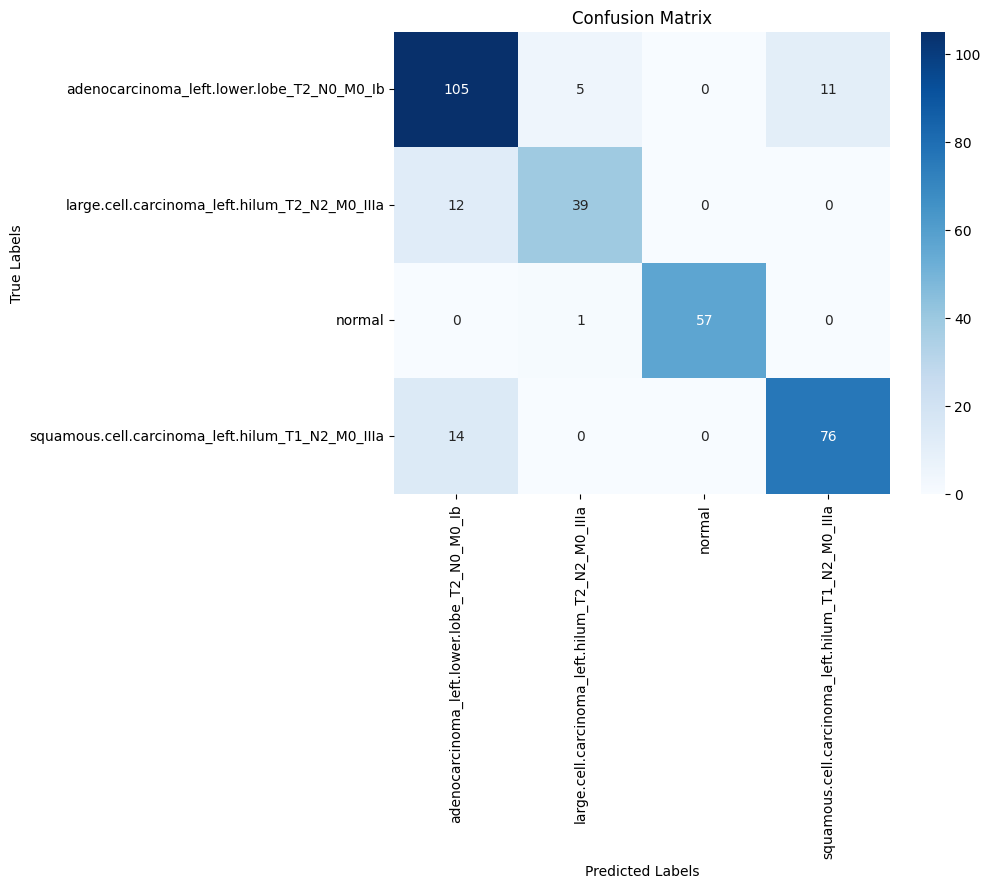

🔹 Classification Report:
                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.80      0.87      0.83       121
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.87      0.76      0.81        51
                                          normal       1.00      0.98      0.99        58
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.87      0.84      0.86        90

                                        accuracy                           0.87       320
                                       macro avg       0.89      0.86      0.87       320
                                    weighted avg       0.87      0.87      0.87       320

🔹 Predicted: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib (Malignant) (Confidence: 72.87%)


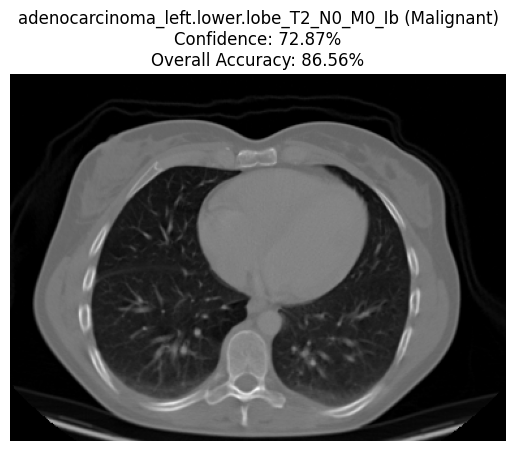

🔹 Predicted: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa (Malignant) (Confidence: 93.75%)


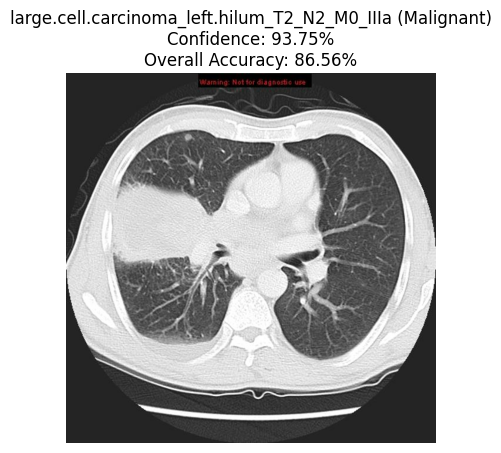

🔹 Predicted: normal (Benign) (Confidence: 99.42%)


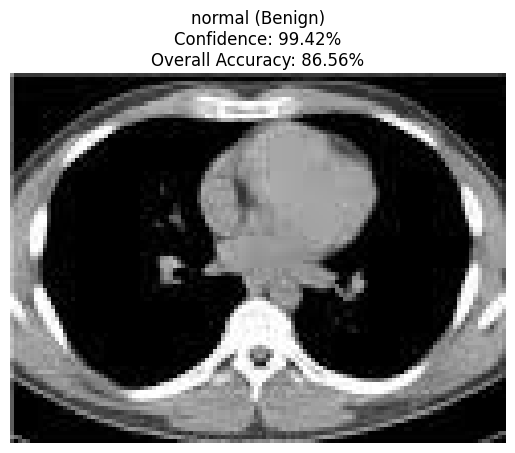

🔹 Predicted: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa (Malignant) (Confidence: 81.80%)


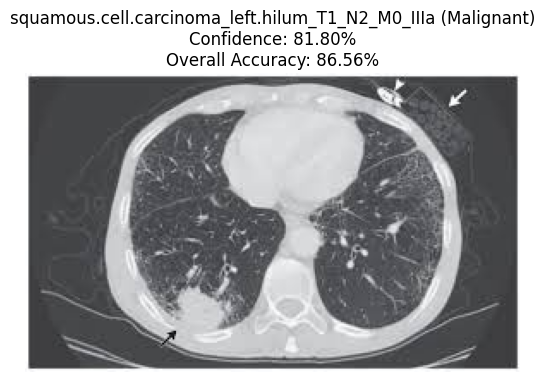

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# ✅ Enable GPU
print("✅ Available GPUs:", tf.config.list_physical_devices('GPU'))

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Define Paths
dataset_path = "/content/drive/MyDrive/Lung-Cancer-Prediction/dataset"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# ✅ Image dimensions & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Data Augmentation & Preprocessing
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_gen = datagen.flow_from_directory(valid_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# ✅ Load Pretrained VGG19 Model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# ✅ Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(len(train_gen.class_indices), activation='softmax')
])

# ✅ Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Training Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ✅ Train Model
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[early_stopping, lr_scheduler])

# ✅ Fine-Tuning VGG19
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# ✅ Recompile Model for Fine-Tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Fine-Tune Model
history_finetune = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[early_stopping, lr_scheduler])

# ✅ Evaluate Model
loss, accuracy = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")

# ✅ Generate Predictions for Confusion Matrix
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ✅ Print Classification Report
print("🔹 Classification Report:\n", classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))

# ✅ Prediction Function with Benign/Malignant Classification
def predict_image(img_path):
    if not os.path.exists(img_path):
        print(f"❌ Error: Image {img_path} not found.")
        return

    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    class_name = list(train_gen.class_indices.keys())[predicted_class]

    # Define malignant and benign class sets based on dataset
    benign_classes = {"benign", "normal"}  # Adjust according to dataset
    malignant_classes = set(train_gen.class_indices.keys()) - benign_classes

    if class_name in benign_classes:
        category = f"Benign"
    elif class_name in malignant_classes:
        category = f"Malignant"
    else:
        category = f"Unknown ({class_name})"

    print(f"🔹 Predicted: {class_name} ({category}) (Confidence: {confidence * 100:.2f}%)")
    plt.imshow(load_img(img_path))
    plt.title(f"{class_name} ({category})\nConfidence: {confidence * 100:.2f}%\nOverall Accuracy: {accuracy * 100:.2f}%")
    plt.axis('off')
    plt.show()

# ✅ Example Usage
predict_image(os.path.join(test_path, "ad.jpg"))
predict_image(os.path.join(test_path, "lc.jpeg"))
predict_image(os.path.join(test_path, "no can.jpeg"))
predict_image(os.path.join(test_path, "sq.jpeg"))

✅ Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 316 images belonging to 4 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 224s 11s/step - accuracy: 0.2747 - loss: 1.4667 - val_accuracy: 0.4167 - val_loss: 1.1961 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.3865 - loss: 1.2124 - val_accuracy: 0.4722 - val_loss: 1.1250 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.5002 - loss: 1.0643 - val_accuracy: 0.4861 - val_loss: 1.0364 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.5551 - loss: 0.9726 - val_accuracy: 0.5000 - val_loss: 1.0670 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.6259 - loss: 0.8788 - val_accuracy: 0.6250 - val_loss: 0.9761 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.6078 - loss: 0.8944 - val_accuracy: 0.4583 - val_loss: 1.0206 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.5942 - loss: 0.8832 - 

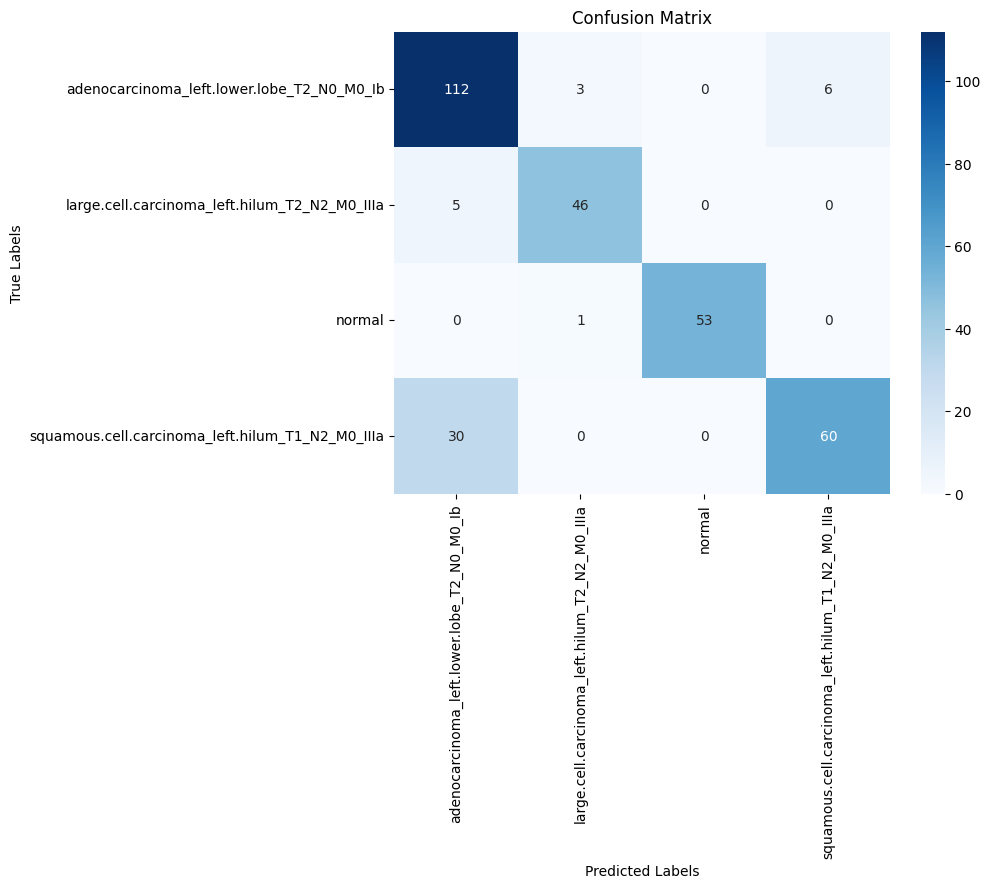

🔹 Classification Report:
                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.76      0.93      0.84       121
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.92      0.90      0.91        51
                                          normal       1.00      0.98      0.99        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.91      0.67      0.77        90

                                        accuracy                           0.86       316
                                       macro avg       0.90      0.87      0.88       316
                                    weighted avg       0.87      0.86      0.86       316



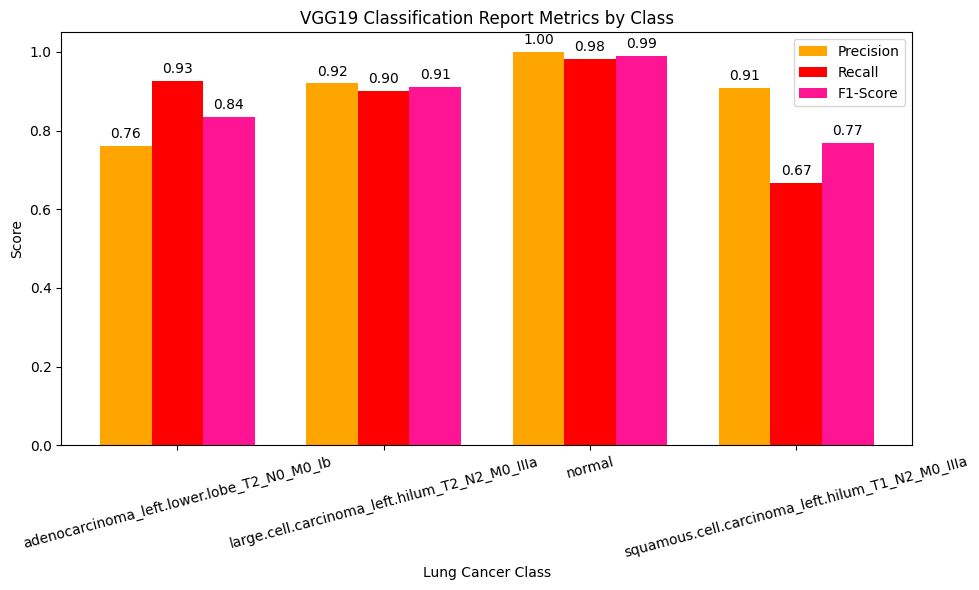

🔹 Predicted: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib (Malignant) (Confidence: 92.40%)


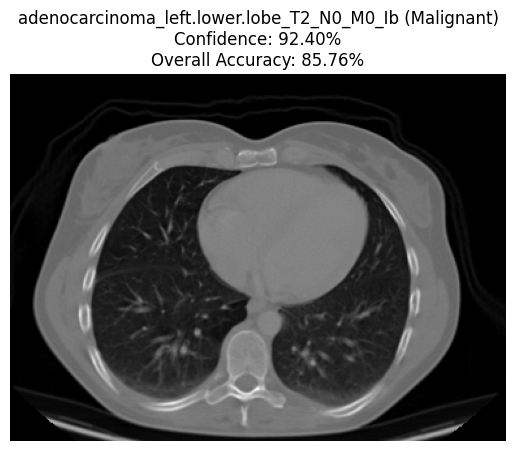

🔹 Predicted: normal (Benign) (Confidence: 99.42%)


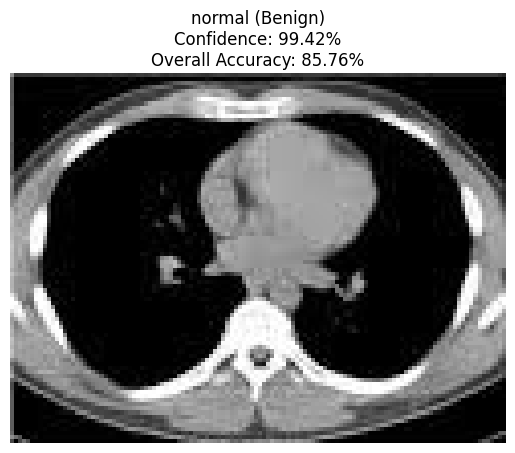

🔹 Predicted: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa (Malignant) (Confidence: 99.16%)


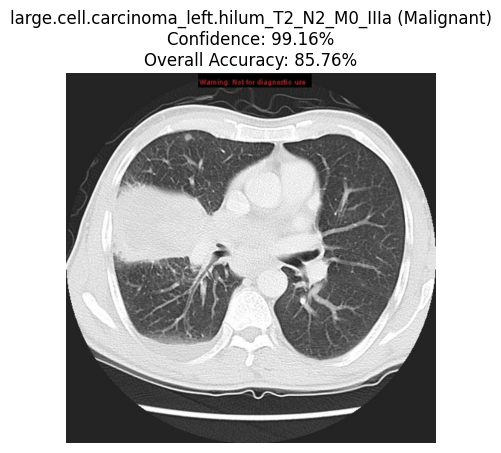

🔹 Predicted: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa (Malignant) (Confidence: 91.50%)


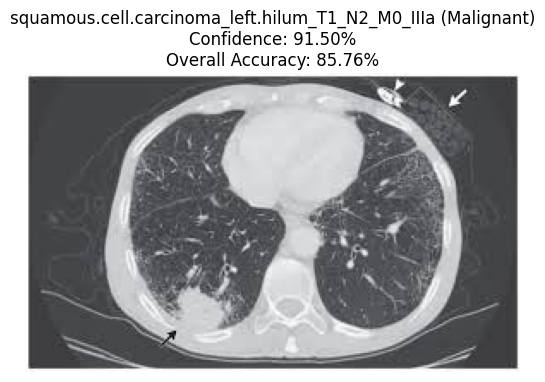

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# ✅ Enable GPU
print("✅ Available GPUs:", tf.config.list_physical_devices('GPU'))

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Define Paths
dataset_path = "/content/drive/MyDrive/Lung-Cancer-Prediction/dataset"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# ✅ Image dimensions & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Data Augmentation & Preprocessing
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_gen = datagen.flow_from_directory(valid_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# ✅ Load Pretrained VGG16 Model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# ✅ Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(len(train_gen.class_indices), activation='softmax')
])

# ✅ Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Training Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ✅ Train Model
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[early_stopping, lr_scheduler])

# ✅ Fine-Tuning ResNet50
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# ✅ Recompile Model for Fine-Tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Fine-Tune Model
history_finetune = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[early_stopping, lr_scheduler])

# ✅ Evaluate Model
loss, accuracy = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")

# ✅ Generate Predictions for Confusion Matrix
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ✅ Print Classification Report
report = classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys(), output_dict=True)
print("🔹 Classification Report:\n", classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))

# ✅ Plot Classification Report Metrics
classes = list(train_gen.class_indices.keys())
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1 = [report[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='orange')
plt.bar(x, recall, width, label='Recall', color='red')
plt.bar(x + width, f1, width, label='F1-Score', color='deeppink')

plt.ylabel('Score')
plt.xlabel('Lung Cancer Class')
plt.title('VGG19 Classification Report Metrics by Class')
plt.xticks(x, classes, rotation=15)

for i in range(len(classes)):
    plt.text(x[i] - width, precision[i] + 0.02, f"{precision[i]:.2f}", ha='center')
    plt.text(x[i], recall[i] + 0.02, f"{recall[i]:.2f}", ha='center')
    plt.text(x[i] + width, f1[i] + 0.02, f"{f1[i]:.2f}", ha='center')

plt.legend()
plt.tight_layout()
plt.show()

# ✅ Prediction Function with Benign/Malignant Classification
def predict_image(img_path):
    if not os.path.exists(img_path):
        print(f"❌ Error: Image {img_path} not found.")
        return

    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    class_name = list(train_gen.class_indices.keys())[predicted_class]

    # Define malignant and benign class sets based on dataset
    benign_classes = {"benign", "normal"}  # Adjust according to dataset

    malignant_classes = set(train_gen.class_indices.keys()) - benign_classes

    if class_name in benign_classes:
        category = f"Benign"
    elif class_name in malignant_classes:
        category = f"Malignant"
    else:
        category = f"Unknown ({class_name})"

    print(f"🔹 Predicted: {class_name} ({category}) (Confidence: {confidence * 100:.2f}%)")
    plt.imshow(load_img(img_path))
    plt.title(f"{class_name} ({category})\nConfidence: {confidence * 100:.2f}%\nOverall Accuracy: {accuracy * 100:.2f}%")
    plt.axis('off')
    plt.show()

# ✅ Example Usage
predict_image(os.path.join(test_path, "ad.jpg"))
predict_image(os.path.join(test_path, "no can.jpeg"))
predict_image(os.path.join(test_path, "lc.jpeg"))
predict_image(os.path.join(test_path, "sq.jpeg"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')